<img src="./Images/HW06_P01.png" width="700px">

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci 
from scipy.integrate import solve_ivp 

In [123]:
# --- Constants --- 
rho_0 = 1.25    # kg/m^3 
g = 9.81    # m/s^2 
y_scale = 10000     # m 

In [ ]:
# --- Function to find calculated values --- 
def proj_eqns(t, Y, m, C, A, drag=True): 
    """ 
    Calculate the air density, drag coefficient, and acceleration due to drag
    Arguments: 
        t: time array (required for solve_ivp, not utilized in this specific function)
        Y: array (4) containing the init conditions 
        m: mass of projectile 
        C: air resistance 
        A: cross sectional area of projectile 
        drag (bool): whether or not to include drag effects 
    Returns: 
        [vx, vy, ax, ay]: directional velocity and acceleration 
    """
    x, y, vx, vy = Y    # match each value of Y to its respective param
    
    v = np.hypot(vx, vy)    # total speed (magnitude)
    if drag:
        rho = rho_0 * np.exp(-y/y_scale)    # air density at height y
        D = 0.5 * C * rho * A   # drag coeff at current height 
        ax = -D/m * vx * v  # accel in x dir 
        ay = -g - D/m * vy * v  # accel in y dir 
    else: 
        ax = 0.0
        ay = -g
    
    return [vx, vy, ax, ay]

# --- Event function to tell solver to stop if/when the projectile hits the ground --- 
def ground(t, Y, *args):
    return Y[1]     # height at y(t)
ground.terminal = True  # stop sim when event happens
ground.direction = -1   # look for sign to change from positive to negative 

def run_sim(angle, v0, m, C, A, drag=True, n=350):
    """ 
    Run a projectile motion simulation using solve_ivp 
    Arguments: 
        angle: launch angle in degrees 
        v0: initial velocity
        m: mass of projectile
        C: air resistance coefficient
        A: cross sectional area of projectile
        drag (bool): include drag or not
        n: number of steps for plottable array 
    Returns: 
        x: x values of solutions 
        y: y values of solutions 
        x_range: distance projectile traveled before landing
        t_ground: how long it took for the projectile to land 
    """
    theta = np.deg2rad(angle)   #convert angle to radians 
    Y0 = [0.0, 1e-6, v0*np.cos(theta), v0*np.sin(theta)]    # put initial conditions into an array for handling
    T = 60  # stopping time for sim
    sol = solve_ivp(proj_eqns, (0, T), Y0, args=(m, C, A, drag), events=ground, dense_output=True)  # run simulation
    t_ground = sol.t_events[0][0]  # define time when projectile landed
    x_range = sol.y_events[0][0,0]  # define distance projectile traveled before landing 
    t_plot = np.linspace(0, t_ground, n)  # create evenly distributed array of values to plot over
    x, y = sol.sol(t_plot)[0], sol.sol(t_plot)[1]  # assign x and y values to the even array 
    return x, y, x_range, t_ground 

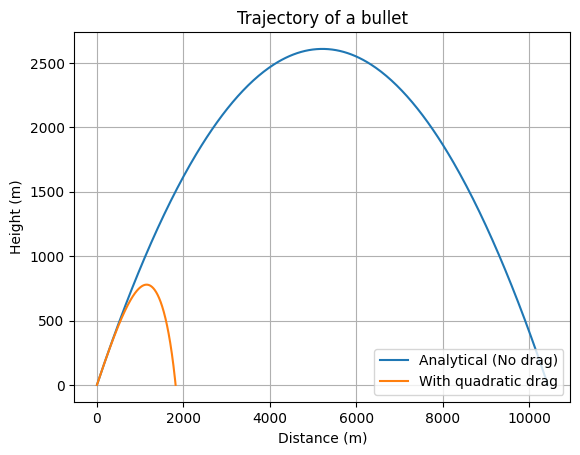

In [ ]:
# --- First projectile --- 

# -- params -- 
m1 = 0.011  # kg -> 11.0g
diam1 = 0.0115    # m -> 1.15cm 
A1 = np.pi*((diam1/2)**2)   # cm^2 
C1 = 0.15   # air resistance 
v0_1 = 320  # m/s 

# -- run sim with and without drag at 45 deg -- 
b_x_nodrag, b_y_nodrag, r_b_nodrag, t_b_nodrag = run_sim(45, v0_1, m1, C1, A1, False)
b_x_drag, b_y_drag, r_b_drag, t_b_drag = run_sim(45, v0_1, m1, C1, A1, True)

# -- plot results -- 
fig, ax = plt.subplots()
ax.set_title("Trajectory of a bullet")
ax.plot(b_x_nodrag, b_y_nodrag, label="Analytical (No drag)")
ax.plot(b_x_drag, b_y_drag, label="With quadratic drag")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="lower right")
ax.grid(True)



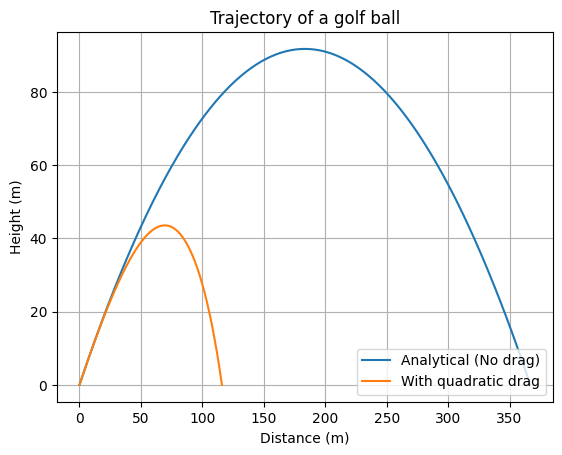

In [ ]:
# --- Second projectile --- 

# -- params --
m2 = 0.046   # kg
diam2 = 0.0427    # m
A2 = np.pi*((diam2/2)**2)   # m^2
C2 = 0.50   # air resistance 
v0_2 = 60.  # m/s

# -- run sim with and without drag at 45 deg --
g_x_nodrag, g_y_nodrag, r_g_nodrag, t_g_nodrag = run_sim(45, v0_2, m2, C2, A2, False)
g_x_drag, g_y_drag, r_g_drag, t_g_drag = run_sim(45, v0_2, m2, C2, A2, True)

# -- plot -- 
fig, ax = plt.subplots()
ax.set_title("Trajectory of a golf ball")
ax.plot(g_x_nodrag, g_y_nodrag, label="Analytical (No drag)")
ax.plot(g_x_drag, g_y_drag, label="With quadratic drag")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="lower right")
ax.grid(True)

In [167]:
# --- Optimal launch angles --- 

def test_range(theta_deg, v0, m, C, A, drag=True):
    theta = np.deg2rad(theta_deg)
    vx0, vy0 = v0*np.cos(theta), v0*np.sin(theta)
    Y0 = [0.0, 1e-6, vx0, vy0]

    T = max(8.0, 1.3*(2*v0*np.sin(theta)/g))
    sol = solve_ivp(proj_eqns, (0,T), Y0, args=(m, C, A, drag), events=ground)

    return sol.y_events[0][0,0]

def best_angle_sweep(v0, m, C, A, drag=True, return_all=False):
    # large sweep 
    thetas = np.arange(10.0, 80.0+1e-9, 2.0)
    ranges = [test_range(th, v0, m, C, A, drag) for th in thetas]
    best_coarse = thetas[int(np.argmax(ranges))]

    # zero in on best coarse angle 
    fine = np.linspace(best_coarse-2.0, best_coarse+2.0, 41)
    fine = fine[(fine>1.0) & (fine<89.0)]
    fine_ranges = [test_range(f, v0, m, C, A, drag) for f in fine]
    th_best = float(fine[int(np.argmax(fine_ranges))])
    r_best = float(np.max(fine_ranges))
    
    return th_best, r_best


th_b_drag, R_b_drag = best_angle_sweep(v0_1, m1, C1, A1, drag=True)
th_g_drag, R_g_drag = best_angle_sweep(v0_2, m2, C2, A2, drag=True)

th_b_nodrag, R_b_nodrag = best_angle_sweep(v0_1, m1, C1, A1, drag=False)
th_g_nodrag, R_g_nodrag = best_angle_sweep(v0_2, m2, C2, A2, drag=False)


print(f"Bullet: drag -- theta = {th_b_drag:.2f}, Max range = {R_b_drag:.0f} m | no drag -- theta = {th_b_nodrag:.2f}, Max range = {R_b_nodrag:.0f} m")
print(f"Golf:   drag -- theta = {th_g_drag:.2f}, Max range = {R_g_drag:.0f} m | no drag -- theta = {th_g_nodrag:.2f}, Max range = {R_g_nodrag:.0f} m")

Bullet: drag -- theta = 34.20, Max range = 1899 m | no drag -- theta = 45.00, Max range = 10438 m
Golf:   drag -- theta = 36.70, Max range = 119 m | no drag -- theta = 45.00, Max range = 367 m


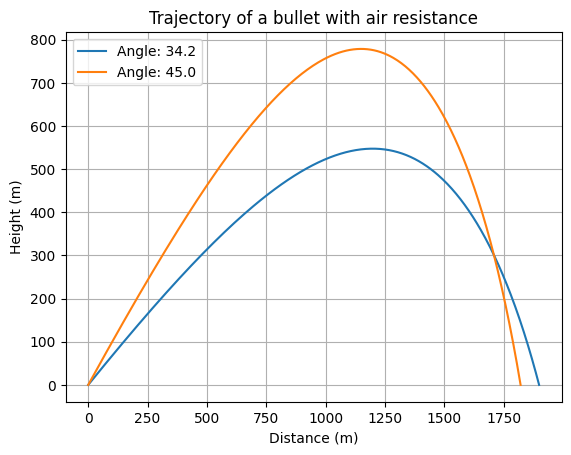

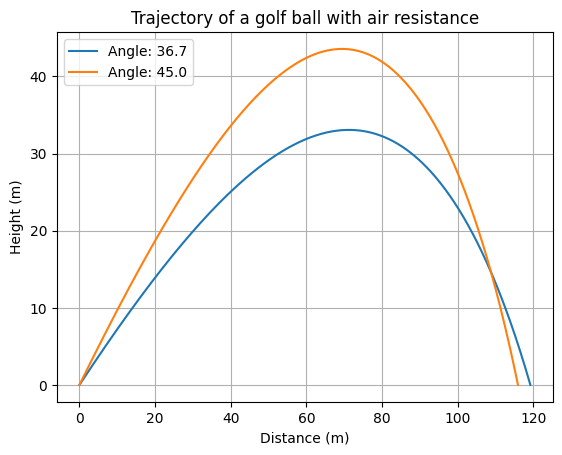

In [188]:

# --- Plot best angle compared to 45 --- 
# -- Bullet --
b_x_best, b_y_best, r_b_best, t_b_best = run_sim(34.20, v0_1, m1, C1, A1, True)
b_x_45, b_y_45, r_b_45, t_b_45 = run_sim(45, v0_1, m1, C1, A1, True)

fig, ax = plt.subplots()
ax.set_title("Trajectory of a bullet with air resistance")
ax.plot(b_x_best, b_y_best, label="Angle: 34.2")
ax.plot(b_x_45, b_y_45, label="Angle: 45.0")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="upper left")
ax.grid(True)

# -- Golf ball -- 
g_x_best, g_y_best, r_g_best, t_g_best = run_sim(36.70, v0_2, m2, C2, A2, True)
g_x_45, g_y_45, r_g_45, t_g_45 = run_sim(45, v0_2, m2, C2, A2, True)

fig, ax = plt.subplots()
ax.set_title("Trajectory of a golf ball with air resistance")
ax.plot(g_x_best, g_y_best, label="Angle: 36.7")
ax.plot(g_x_45, g_y_45, label="Angle: 45.0")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="upper left")
ax.grid(True)

